# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Data Cleaning

## Selecting Relevant Fields
the dataset will be loaded and transformed and relevant dimensions will remain

In [ ]:
df = pd.read_csv('database.csv')[[
    'NAME_CONTRACT_STATUS',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'OCCUPATION_TYPE',
    'CNT_FAM_MEMBERS',
    'NAME_CLIENT_TYPE',
    'AMT_DOWN_PAYMENT',
    'NAME_TYPE_SUITE',
    'NAME_PAYMENT_TYPE'
]]

#drop rows with na values
df = df.dropna()
for col in df.columns:
    df = df[df[col]!='XNA'].reset_index(drop=True)

#shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

df.head(6)

## Reductions to Binary Variables

The target variable, NAME_CONTRACT_STATUS, will be reduced from one of 4 possible values, to one of two generic but still correct values – for example, the dataset distingushes between cancelled and rejected and granted loans, however we will only distinguish between granted and not granted loans. Values that are binary but that don't use the binary alphabet will be transformed to use the binary alphabet as well.

Defining a function that will return a copy of the dataframe with reduced fields.

In [ ]:
def reduce(df, name, value):
    if type(name) != str:
        raise Exception('only one dimension is reduced at a time')
    idx_name = df.columns.get_loc(name)
    reduced = [(1 if df[name][i] == value else 0) for i in range(len(df))]
    df_reduced = df.drop(labels=[name], axis=1)
    df_reduced.insert(loc=idx_name, column=name, value=reduced)
    return df_reduced

In [ ]:
df_reduced = df
df_reduced = reduce(df_reduced, 'NAME_CONTRACT_STATUS', 'Approved') # 1 if approved else 0
df_reduced = reduce(df_reduced, 'CODE_GENDER', 'M') # 1 if male else 0
df_reduced = reduce(df_reduced, 'FLAG_OWN_CAR', 'Y') # 1 if owns car else 0
df_reduced = reduce(df_reduced, 'FLAG_OWN_REALTY', 'Y') # 1 if owns property else 0

df_reduced.head(10)

## One-Hot Encoding
defining a function that returns a copy of the input dataframe with a specific dimension one-hot encoded

In [ ]:
def one_hot_encode(df, name, prefix=''):
    if type(name) != str:
        raise Exception('one hot encoding applies to one dimension at a time')
    if len(df) == 0:
        raise Exception('dataframe is empty')
    
    df = df.copy()
    values = df[name].unique()
    
    #for each unique value, we create a new column where df[row][new column] is 1 if the value of df[row][value] == new column
    for v in values:
        one_hot_column = [(1 if df[name][i] == v else 0) for i in range(len(df))]
        df.insert(loc=len(df.loc[0]), column=prefix + str(v), value=one_hot_column)

    return df.drop(labels=[name], axis=1)

performing one-hot encoding on any dimension whose values are one of a set of string values

In [ ]:
df_encoded = df_reduced
df_encoded = one_hot_encode(df_encoded, 'NAME_INCOME_TYPE')
df_encoded = one_hot_encode(df_encoded, 'NAME_EDUCATION_TYPE')
df_encoded = one_hot_encode(df_encoded, 'NAME_FAMILY_STATUS')
df_encoded = one_hot_encode(df_encoded, 'NAME_HOUSING_TYPE')
df_encoded = one_hot_encode(df_encoded, 'OCCUPATION_TYPE')
df_encoded = one_hot_encode(df_encoded, 'CNT_FAM_MEMBERS', prefix='CNT_FAM_MEM_')
df_encoded = one_hot_encode(df_encoded, 'NAME_CLIENT_TYPE')
df_encoded = one_hot_encode(df_encoded, 'NAME_TYPE_SUITE')
df_encoded = one_hot_encode(df_encoded, 'NAME_PAYMENT_TYPE')
df_all_features = df_encoded

#sanity check the dataframe before any work on it begins
df_all_features.head(10)

# Training the models

## Split the dataframe into X and y as numpy arrays

normalize the data

In [ ]:
from sklearn import preprocessing
to_scale = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'AMT_DOWN_PAYMENT'
]
subframe = df_all_features[to_scale].copy()
scaler = preprocessing.MinMaxScaler().fit(subframe.values)
subframe = scaler.transform(subframe.values)
df_all_features[to_scale] = subframe
df_final = df_all_features

convert the dataframe into a numpy tensor

In [ ]:
data = np.array(df_final)

#undersample the target 1's so that the dataset is exactly balanced
num_zero = len(data[data[:,0]==0])
num_one = num_zero

#balance the amount of approvals and rejections
data = np.vstack((
    data[data[:,0]==1][:num_one,:],
    data[data[:,0]==0]
))
np.random.shuffle(data)

X = data[:,1:]
y = data[:,0].astype(np.int32)

## Creating the test class
We will create a class that collects everything we need to build and to analyze a model. The class will point to our data, and to a model building algorithm, and will provide functionality for presenting results.

In [ ]:
from sklearn.model_selection import KFold

class Test:
    def __init__(self, name, X, y, algorithm, args):
        self.name = name
        self.X = X  #pointer, not copy
        self.y = y
        self.algorithm = algorithm
        self.args = args
        
        self.predictions=None
        self.accs_train=None
        self.accs_test=None
        self.best_acc_index=None
        self.models = None
    
    def get_args(self):
        return dict(self.args)
    
    def get_models(self):
        if self.models is None:
            raise Exception('test has not yet been run')
        return list(self.models)
    
    def get_model(self):
        return self.get_models()[self.best_acc_index]
    
    def get_training_accuracies(self):
        if self.accs_train is None:
            raise Exception('test has not yet been run')
        return list(self.accs_train)

    def get_accuracy_training(self):
        return self.get_training_accuracies()[self.best_acc_index]

    def get_testing_accuracies(self):
        if self.accs_test is None:
            raise Exception('test has not yet been run')
        return list(self.accs_test)
    
    def get_accuracy(self):
        return self.get_testing_accuracies()[self.best_acc_index]

    def get_predictions(self):
        if self.predictions is None:
            raise Exception('test has not yet been run')
        return list(self.predictions)
    
    def get_best_prediction(self):
        return self.get_predictions()[self.best_acc_index]
    
    #obtain accuracy using k-fold cross validation
    def run(self, k_fold_splits=5):

        predictions = []
        accs_train = []
        accs_test = []
        best_acc_test = 0
        best_acc_index = 0
        models = []
        
        kfold_model = KFold(n_splits=k_fold_splits, random_state=None, shuffle=False)
        
        i = 0
        for train_index, test_index in kfold_model.split(self.X):
            X_train = self.X[train_index]
            y_train = self.y[train_index]
            X_test = self.X[test_index]
            y_test = self.y[test_index]
            model = self.algorithm(**self.args)
            model.fit(X_train, y_train)
            models.append(model)
            accs_train.append(model.score(X_train,y_train))
            acc_test = model.score(X_test,y_test)
            accs_test.append(acc_test)
            if acc_test > best_acc_test:
                best_acc_test = acc_test
                best_acc_index = i
            predictions.append(model.predict(X_test))
            i += 1
        
        self.accs_test = accs_test
        self.predictions = predictions
        self.accs_train = accs_train
        self.best_acc_index = best_acc_index
        self.models = models

    
    def display(self):
        print(f'\n\n{self.name}\n' + '='*len(self.name))
        acc_train = self.get_accuracy_training()
        acc_test = self.get_accuracy()
        prediction = self.get_best_prediction()
        print(f'Mean prediction: {np.round(np.mean(np.array(prediction)), 2)}')
        print(f'Training accuracy: {acc_train}')
        print(f'Test accuracy: {acc_test}')

## Support Vector Machine Modelling
The motivation behind support vector machines is that we are building a line of best fit between two datasets, where "best" is defined by an objective function of distance between our line of best fit and between critical points, called support vectors, of these datasets. Support vectors are the closest points to a line of best fit. Our best fit line is also a decision boundary.

In [ ]:
from sklearn import svm

In [ ]:
svm_linear_tests = [
    Test(
        name=f'SVM linear with C of {i}',
        X=X,
        y=y,
        algorithm=svm.SVC,
        args={'kernel': 'linear', 'C': i}
    )
    for i in [0.001, 0.01, 0.1, 1, 10]
]

# run tests
for test in svm_linear_tests:
    test.run()
    test.display()

In [ ]:
svm_rbf_tests = [
    Test(
        name=f'SVM rbf of with C of {i}',
        X=X,
        y=y,
        algorithm=svm.SVC,
        args={'kernel': 'rbf', 'C': i}
    )
    for i in [0.001, 0.01, 0.1, 1, 10]
]


#run tests while recording values to plot
svm_rbf_acc_train = [] 
svm_rbf_acc_test = []
svm_rbf_c = []

for test in svm_rbf_tests:
    test.run()
    test.display()
    svm_rbf_c.append(test.get_args()['C'])
    svm_rbf_acc_train.append(test.get_accuracy_training())
    svm_rbf_acc_test.append(test.get_accuracy())


print("plot of how accuracy changes on the single parameter C")
plt.title('Accuracy vs C')
plt.plot(svm_rbf_c,svm_rbf_acc_train)
plt.plot(svm_rbf_c,svm_rbf_acc_test)
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='lower right')

In [ ]:
pairs = []
for degree in range(1,6):
    for C in [0.01, 0.1, 1]:
        pairs.append((degree, C))

svm_poly_tests = [
    Test(
        name=f'SVM poly of degree {degree} and with C of {C}',
        X=X,
        y=y,
        algorithm=svm.SVC,
        args={'kernel': 'poly', 'C': C, 'degree': degree}
    )
    for (degree, C) in pairs
]

for test in svm_poly_tests:
    test.run()
    test.display()

## Logistic Regression Modelling
The motivation behind Logistic Regression modelling is that we attempt to *explain*, by defining a **likely** decision boundary, why a specific dataset is split the way it is. Our objective function is best when it is most likely the explanation for the given dataset split. We avoid overfitting by introducing a penalty function that is some function of weights that is then scaled by a ∆.

In [ ]:
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)



Logreg l1 penalty with ∆=0.0001
Mean prediction: 0.0
Training accuracy: 0.49409953822473063
Test accuracy: 0.5236139630390144


Logreg l1 penalty with ∆=0.001
Mean prediction: 1.0
Training accuracy: 0.4961518727552591
Test accuracy: 0.5154004106776181


Logreg l1 penalty with ∆=0.01
Mean prediction: 0.28
Training accuracy: 0.6346844535659313
Test accuracy: 0.6529774127310062


Logreg l1 penalty with ∆=0.1
Mean prediction: 0.28
Training accuracy: 0.6346844535659313
Test accuracy: 0.6529774127310062


Logreg l1 penalty with ∆=1
Mean prediction: 0.41
Training accuracy: 0.6469984607491021
Test accuracy: 0.6365503080082136


Logreg l1 penalty with ∆=10
Mean prediction: 0.43
Training accuracy: 0.6572601334017445
Test accuracy: 0.6386036960985626


coefficents: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

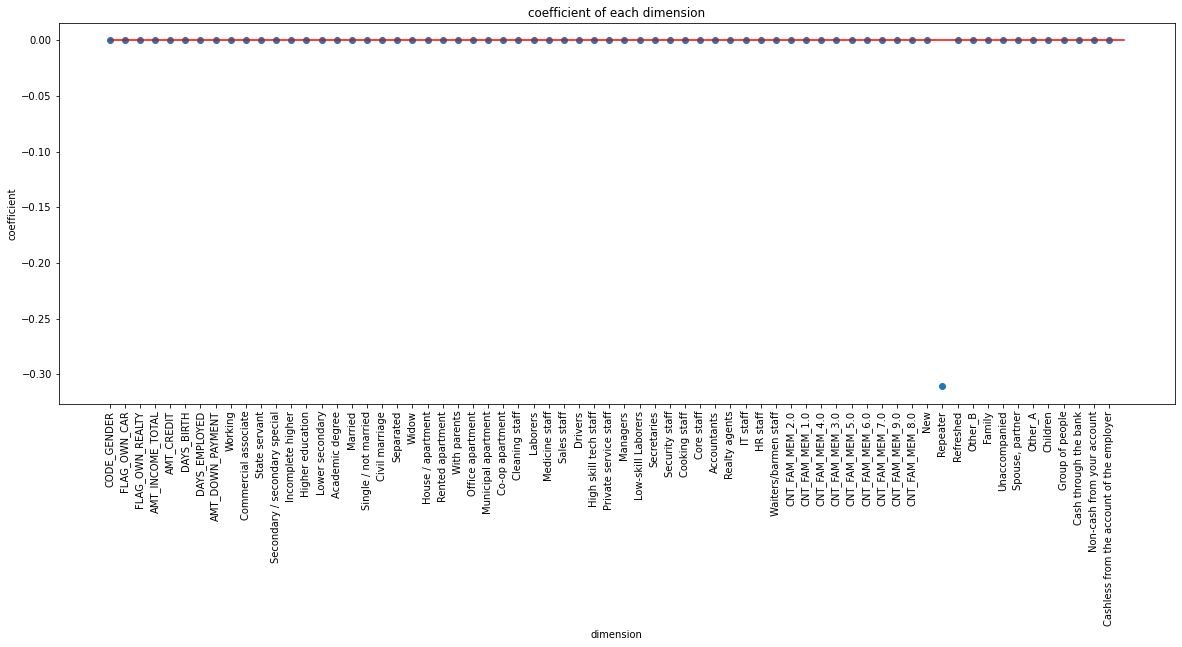

In [71]:
logreg_l1_tests = [
    Test(
        name=f'Logreg l1 penalty with ∆={i}',
        X=X,
        y=y,
        algorithm=linear_model.LogisticRegression,
        args={'penalty':'l1', 'solver':'saga', 'C':i}
    )
    for i in [0.0001, 0.001, 0.01, 0.1, 1, 10]
]

best_model = None
best_accuracy = 0
for test in logreg_l1_tests:
    test.run()
    test.display()
    accuracy = test.get_accuracy()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = test.get_model()

print('\n')
coefs = np.round(best_model.coef_.ravel(),3).tolist()
print(f'coefficents: {coefs}')
plt.figure(figsize=(20,7))
plt.title('coefficient of each dimension')
plt.scatter(
    df_final.columns[1:].tolist(),  #'1:' to avoid the target variable
    coefs
)
plt.tick_params(axis='x', rotation = 90)
plt.xlabel('dimension')
plt.ylabel('coefficient')
plt.plot([0,len(coefs)],[0,0],c='red')
plt.show()




Logreg l2 penalty with ∆=0.0001
Mean prediction: 0.53
Training accuracy: 0.6192919445869677
Test accuracy: 0.6098562628336756


Logreg l2 penalty with ∆=0.001
Mean prediction: 0.33
Training accuracy: 0.6326321190354027
Test accuracy: 0.6406570841889117


Logreg l2 penalty with ∆=0.01
Mean prediction: 0.31
Training accuracy: 0.6341713699332991
Test accuracy: 0.6550308008213552


Logreg l2 penalty with ∆=0.1
Mean prediction: 0.35
Training accuracy: 0.633658286300667
Test accuracy: 0.6406570841889117


Logreg l2 penalty with ∆=1
Mean prediction: 0.4
Training accuracy: 0.6480246280143663
Test accuracy: 0.6262833675564682


Logreg l2 penalty with ∆=10
Mean prediction: 0.42
Training accuracy: 0.6613648024628014
Test accuracy: 0.6344969199178645


coefficents: [-0.069, -0.033, 0.038, 0.002, -0.076, -0.083, -0.066, 0.003, 0.026, -0.021, -0.005, 0.046, -0.049, -0.02, 0.017, 0.006, 0.096, -0.093, -0.03, -0.006, 0.033, 0.074, 0.008, -0.07, -0.007, -0.006, 0.001, -0.012, -0.029, 0.007, -0.06, -0

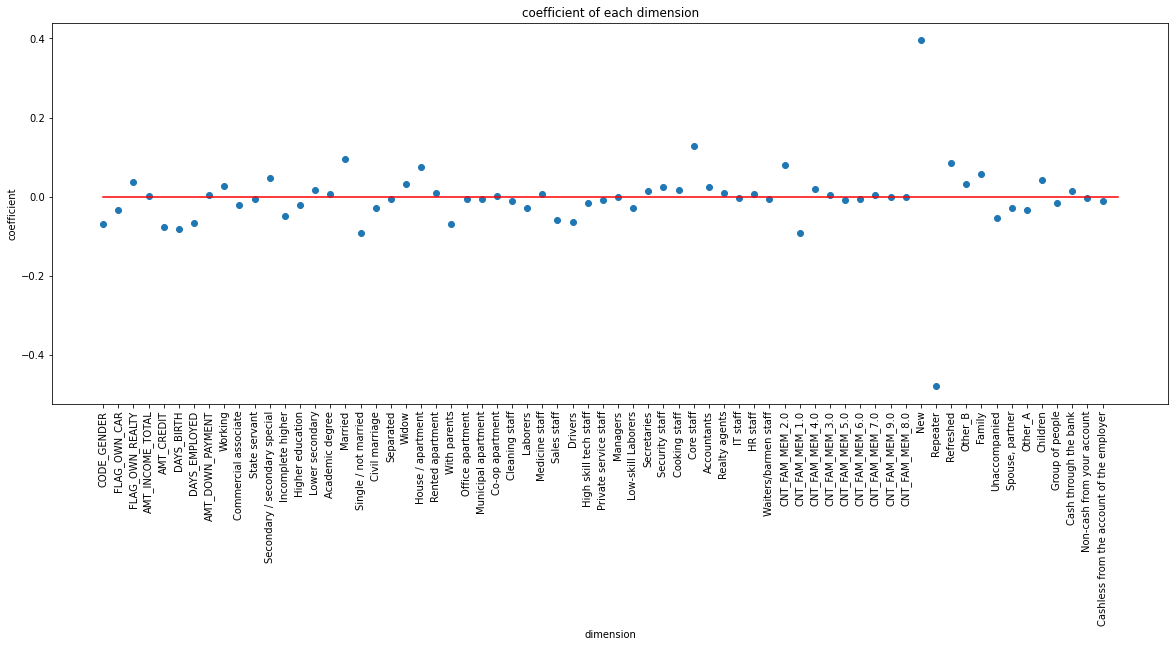

In [72]:
logreg_l2_tests = [
    Test(
        name=f'Logreg l2 penalty with ∆={i}',
        X=X,
        y=y,
        algorithm=linear_model.LogisticRegression,
        args={'penalty':'l2', 'solver':'saga', 'C':i}
    )
    for i in [0.0001, 0.001, 0.01, 0.1, 1, 10]
]


best_model = None
best_accuracy = 0
for test in logreg_l2_tests:
    test.run()
    test.display()
    accuracy = test.get_accuracy()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = test.get_model()

print('\n')
coefs = np.round(best_model.coef_.ravel(),3).tolist()
print(f'coefficents: {coefs}')
plt.figure(figsize=(20,7))
plt.title('coefficient of each dimension')
plt.scatter(
    df_final.columns[1:].tolist(),  #'1:' to avoid the target variable
    coefs
)
plt.tick_params(axis='x', rotation = 90)
plt.xlabel('dimension')
plt.ylabel('coefficient')
plt.plot([0,len(coefs)],[0,0],c='red')
plt.show()

## Neural Network Modelling
The motvation behind neural network modelling is that we attempt to define abstractions that are functions of other abstractions that are functions of our input. At a high level, a neural network is a set of functions that are defined as computation graphs. To improve our function, we find the gradient of our augmented error function that includes a penalty function, just as in logistic regression.

In [ ]:
#code reference: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier

In [ ]:
nn_sgd_tests = [
    Test(
        name='NN using stochastic gradient descent and logistic activation with small ∆',
        X=X,
        y=y,
        algorithm=MLPClassifier,
        args={'solver': 'sgd', 'activation':'logistic', 'alpha': 1e-5, 'hidden_layer_sizes': (6,4,2), 'random_state': 52}
    ),
    Test(
        name='NN using stochastic gradient descent and logistic activation with large ∆',
        X=X,
        y=y,
        algorithm=MLPClassifier,
        args={'solver': 'sgd', 'activation':'logistic', 'alpha': 10, 'hidden_layer_sizes': (6,4,2), 'random_state': 1245}
    ),
    Test(
        name='NN using stochastic gradient descent and relu activation with small ∆',
        X=X,
        y=y,
        algorithm=MLPClassifier,
        args={'solver': 'sgd', 'activation':'relu', 'alpha': 1e-8, 'hidden_layer_sizes': (5,2), 'random_state': 734}
    ),
    Test(
        name='NN using stochastic gradient descent and relu activation with large ∆',
        X=X,
        y=y,
        algorithm=MLPClassifier,
        args={'solver': 'sgd', 'activation':'relu', 'alpha': 1, 'hidden_layer_sizes': (5,2), 'random_state': 734}
    )
]

for test in nn_sgd_tests:
    test.run()
    test.display()

In [ ]:
lambdas = [
    1e-4,
    1,
    1e2,
]
structures = [
    (4,3),
    (9,6),
    (9,6,3),
    (10,6),
    (10,8,6,4,2)
]
pairs = []
for structure in structures:
    for lmbda in lambdas:
        pairs.append((structure, lmbda))

nn_logistic_tests = [
    Test(
        name=f'NN with hidden layers of {structure} and with lmbda of {lmbda} and with activation of logistic function',
        X=X,
        y=y,
        algorithm=MLPClassifier,
        args={
            'solver': 'lbfgs',
            'alpha': lmbda,
            'activation': 'logistic',
            'hidden_layer_sizes': structure,
            'random_state': 1
        }
    )
    for (structure, lmbda) in pairs
]

for test in nn_logistic_tests:
    test.run()
    test.display()

In [ ]:
pairs = []
lambdas = [
    1e-4,
    1,
    1e2,
]
random_weights = [i*17 for i in range(1,7)]

structure = (4,3) #best results in previous demo

for rw in random_weights:
    for lmbda in lambdas:
        pairs.append((rw,lmbda))

nn_relu_tests = [
    Test(
        name=f'NN with hidden layers = {structure}; lmbda = {lmbda}; random weight seed = {rw}; activation = relu',
        X=X,
        y=y,
        algorithm=MLPClassifier,
        args={
            'solver': 'lbfgs',
            'alpha': lmbda,
            'activation': 'relu',
            'hidden_layer_sizes': structure,
            'random_state': rw
        }
    )
    for (rw, lmbda) in pairs
]

for test in nn_relu_tests:
    test.run()
    test.display()